# Transfer Learning with TensorFlow Part 3: Scaling up

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101.

Our goal is to beat the original Food101 paper with 10% of the training.
Our baseline to beat it 50.76% accuracy.


## Creating helper functions 

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them 

In [ ]:
# Import helper functions 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2022-08-01 12:14:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-01 12:14:14 (64.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for our notebook 
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes : working with less data 

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

In [ ]:
# import data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

--2022-08-01 12:14:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.214.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   118MB/s    in 13s     

2022-08-01 12:14:34 (121 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

In [ ]:
# Walkthrough data 
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/breakfast_burrito'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/seaweed_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tacos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ravioli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheese_plate'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hummus'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_foo

In [ ]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = 'categorical',
                                                                                image_size = IMG_SIZE)

test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                                label_mode = 'categorical',
                                                                                image_size = IMG_SIZE,
                                                                                shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with tranfer learning on 10% of 101 food classes

Here are the step's we're going to take:
* Create a ModelCheckpoint cast_eager_fallback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model 
* Feature extract for 5 full passes ( 5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [ ]:
# Create checkpoint callback

checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = 'val_accuracy',
                                                         save_best_only = True)

In [ ]:
# Create data augmentation layer 
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential 

# Setup data augmentation 
data_augmentation = Sequential([
                                preprocessing.RandomFlip('horizontal'),
                                preprocessing.RandomRotation(0.2),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                #preprocessing.Rescaling(1/255.) #recaled inputus of images to between 0 & 1, EfficientNetB0 already does ths but others might need it 
], name = 'data_augmentation')

In [ ]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

# Setup model architecture with trainable top layrs
inputs = layers.Input(shape = (224, 224, 3), name = "input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training = False) # puts the base model in inference mode so weights which need to stay frozen stay frozen 
x = layers.GlobalAveragePooling2D(name = 'global_avg_pool_layer')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation= 'softmax', name = 'output_layer')(x)
model = tf.keras.Model(inputs, outputs)


16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
from tensorflow.python.ops.variables import validate_synchronization_aggregation_trainable
# Compile the model 
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs = 5, 
                                           validation_data = test_data_all_10_percent,
                                           validation_steps = int(0.15 * len(test_data_all_10_percent)),
                                           callbacks = [checkpoint_callback])


Epoch 1/5
237/237 [==============================] - 608s 3s/step - loss: 3.4580 - accuracy: 0.2454 - val_loss: 2.6506 - val_accuracy: 0.4060
Epoch 2/5
237/237 [==============================] - 616s 3s/step - loss: 2.3442 - accuracy: 0.4581 - val_loss: 2.2076 - val_accuracy: 0.4733
Epoch 3/5
237/237 [==============================] - 622s 3s/step - loss: 1.9804 - accuracy: 0.5249 - val_loss: 2.0599 - val_accuracy: 0.4815
Epoch 4/5
237/237 [==============================] - 662s 3s/step - loss: 1.7610 - accuracy: 0.5765 - val_loss: 2.0124 - val_accuracy: 0.4881
Epoch 5/5
237/237 [==============================] - 665s 3s/step - loss: 1.5823 - accuracy: 0.6177 - val_loss: 1.9599 - val_accuracy: 0.4931


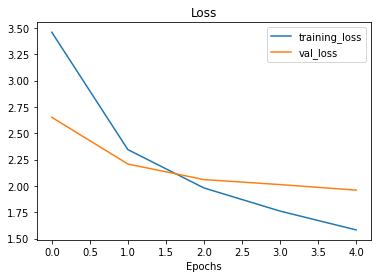

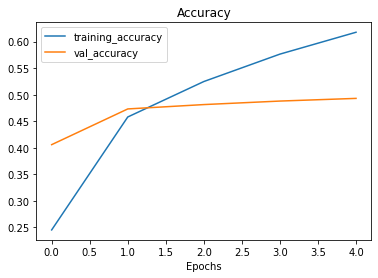

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

In [ ]:
# Evaluate on whole test data set
feature_extraction_results = model.evaluate(test_data_all_10_percent)
feature_extraction_results

790/790 [==============================] - 1375s 2s/step - loss: 1.7287 - accuracy: 0.5493


[1.7287001609802246, 0.5493069291114807]

 Ideally the two curves should be very similar to each other, if not it may suuggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data)

### Fine tuning

In [ ]:
# Unfreeze all of the layers in the base model 
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate (it's typically best practice to lower learning rate when fine tuning)
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001),
              metrics = ['accuracy'])


In [ ]:
# What layers in the model are trainable 
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
# Check which layer are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number,layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Fine-tune for 5 more epochs 
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), then we want to unfreeze and continue fine tuning

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data = test_data_all_10_percent,
                                                     validation_steps = int(0.15 * len(test_data_all_10_percent)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 755s 3s/step - loss: 0.9635 - accuracy: 0.7460 - val_loss: 1.9225 - val_accuracy: 0.5056
Epoch 6/10
237/237 [==============================] - 761s 3s/step - loss: 0.9105 - accuracy: 0.7597 - val_loss: 1.9635 - val_accuracy: 0.5000
Epoch 7/10
237/237 [==============================] - 752s 3s/step - loss: 0.8661 - accuracy: 0.7732 - val_loss: 1.9430 - val_accuracy: 0.5056
Epoch 8/10
237/237 [==============================] - 768s 3s/step - loss: 0.8249 - accuracy: 0.7807 - val_loss: 1.9487 - val_accuracy: 0.5024
Epoch 9/10
237/237 [==============================] - 702s 3s/step - loss: 0.7733 - accuracy: 0.7919 - val_loss: 1.8976 - val_accuracy: 0.5183
Epoch 10/10
237/237 [==============================] - 748s 3s/step - loss: 0.7494 - accuracy: 0.8045 - val_loss: 1.9300 - val_accuracy: 0.5124


In [ ]:
# Evaluate on the whole test data 
all_classes_10_percent_fine_tune_result = model.evaluate(test_data_all_10_percent)
all_classes_10_percent_fine_tune_result

790/790 [==============================] - 1411s 2s/step - loss: 1.6256 - accuracy: 0.5760


[1.625551462173462, 0.5759999752044678]

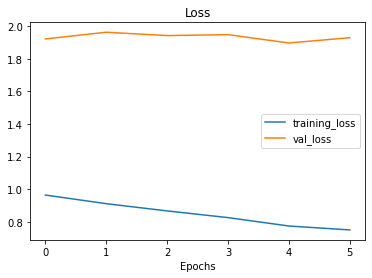

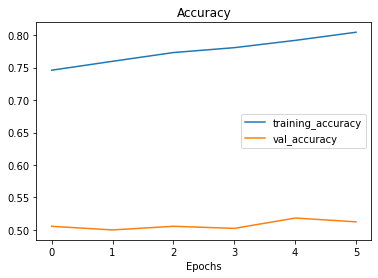

In [ ]:
plot_loss_curves(history_all_classes_10_percent_fine_tune)

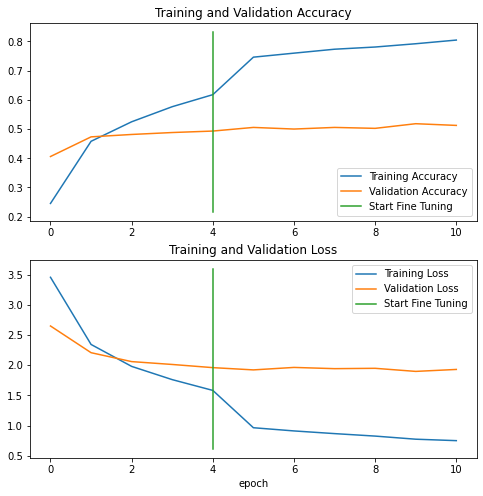

In [ ]:
# Compare the histories of feature extraction model with fine tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs =5)

## Saving and loading our model

In [ ]:
# Save our fine tuning model 
model.save("drive/Mydrive/Personal Projects/TensorFlow Cert/101_food_classes_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: drive/Mydrive/TensorFlow Cert/101_food_classes_10_percent_saved_big_dog_model/assets


INFO:tensorflow:Assets written to: drive/Mydrive/TensorFlow Cert/101_food_classes_10_percent_saved_big_dog_model/assets


In [ ]:
# Load model
loaded_model =tf.keras.models.load_model("drive/Mydrive/Personal Projects/TensorFlow Cert/101_food_classes_10_percent_saved_big_dog_model")

OSError: ignored

## Evaluating the performance of the big dog model across all different classes 

Let's make some predictions, visualize them and then later find out which predictions were the most wrong.

In [ ]:
import tensorflow as tf
# Download pretrained saved model (one that was prepared earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip 


--2022-08-01 12:42:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 172.217.203.128, 172.253.123.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   105MB/s    in 0.4s    

2022-08-01 12:42:19 (105 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Load in saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model 
results_downloaded_model = model.evaluate(test_data_all_10_percent)
results_downloaded_model

790/790 [==============================] - 1273s 2s/step - loss: 1.8027 - accuracy: 0.6078


[1.8027209043502808, 0.6077623963356018]

## Making predictions with our trained model 

In [ ]:
#make predictions with model
preds_probs = model.predict(test_data_all_10_percent, verbose=1)

790/790 [==============================] - 1269s 2s/step


In [ ]:
# Each prediction has a 101 possibilities one for each class 
len(preds_probs[0])

101

In [ ]:
max(preds_probs[0])

0.84741837

In [ ]:
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like: {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")
print(f"The class name of the highest predicted probability by the model for sample 0: {test_data_all_10_percent.class_names[preds_probs[0].argmax()]}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like: [5.95417581e-02 3.57424847e-06 4.13771980e-02 1.06606735e-09
 8.16151857e-09 8.66402861e-09 8.09278674e-07 8.56524650e-07
 1.98591606e-05 8.09788219e-07 3.17282178e-09 9.86751274e-07
 2.85323709e-04 7.80496168e-10 7.42299249e-04 3.89164416e-05
 6.47409070e-06 2.49774644e-06 3.78914447e-05 2.06784591e-07
 1.55386842e-05 8.15073861e-07 2.62307344e-06 2.00107735e-07
 8.38279050e-07 5.42163843e-06 3.73912712e-06 1.31506290e-08
 2.77614221e-03 2.80515869e-05 6.85629165e-10 2.55749692e-05
 1.66890517e-04 7.64084296e-10 4.04531718e-04 1.31507800e-08
 1.79576114e-06 1.44482931e-06 2.30628923e-02 8.24675396e-07
 8.53664005e-07 1.71386398e-06 7.05264210e-06 1.84023001e-08
 2.85535606e-07 7.94833522e-06 2.06819391e-06 1.85251992e-07
 3.36198873e-08 3.15227226e-04 1.04110095e-05 8.54496420e-07
 8.47418368e-01 1.05555127e-05 4.40949037e-07 3.74044866e-05
 3.53064534e-05 3.24891553e-05 6.73144023e-0

In [ ]:
pred_classes = preds_probs.argmax(axis = 1)

In [ ]:
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

 Now we've got a prediction array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data_all_10_percent.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating our model's predictions 
one way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels, y_pred = pred_classes)

In [ ]:
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

## let's get visual, making a confusion matrix

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
class_names = test_data_all_10_percent.class_names

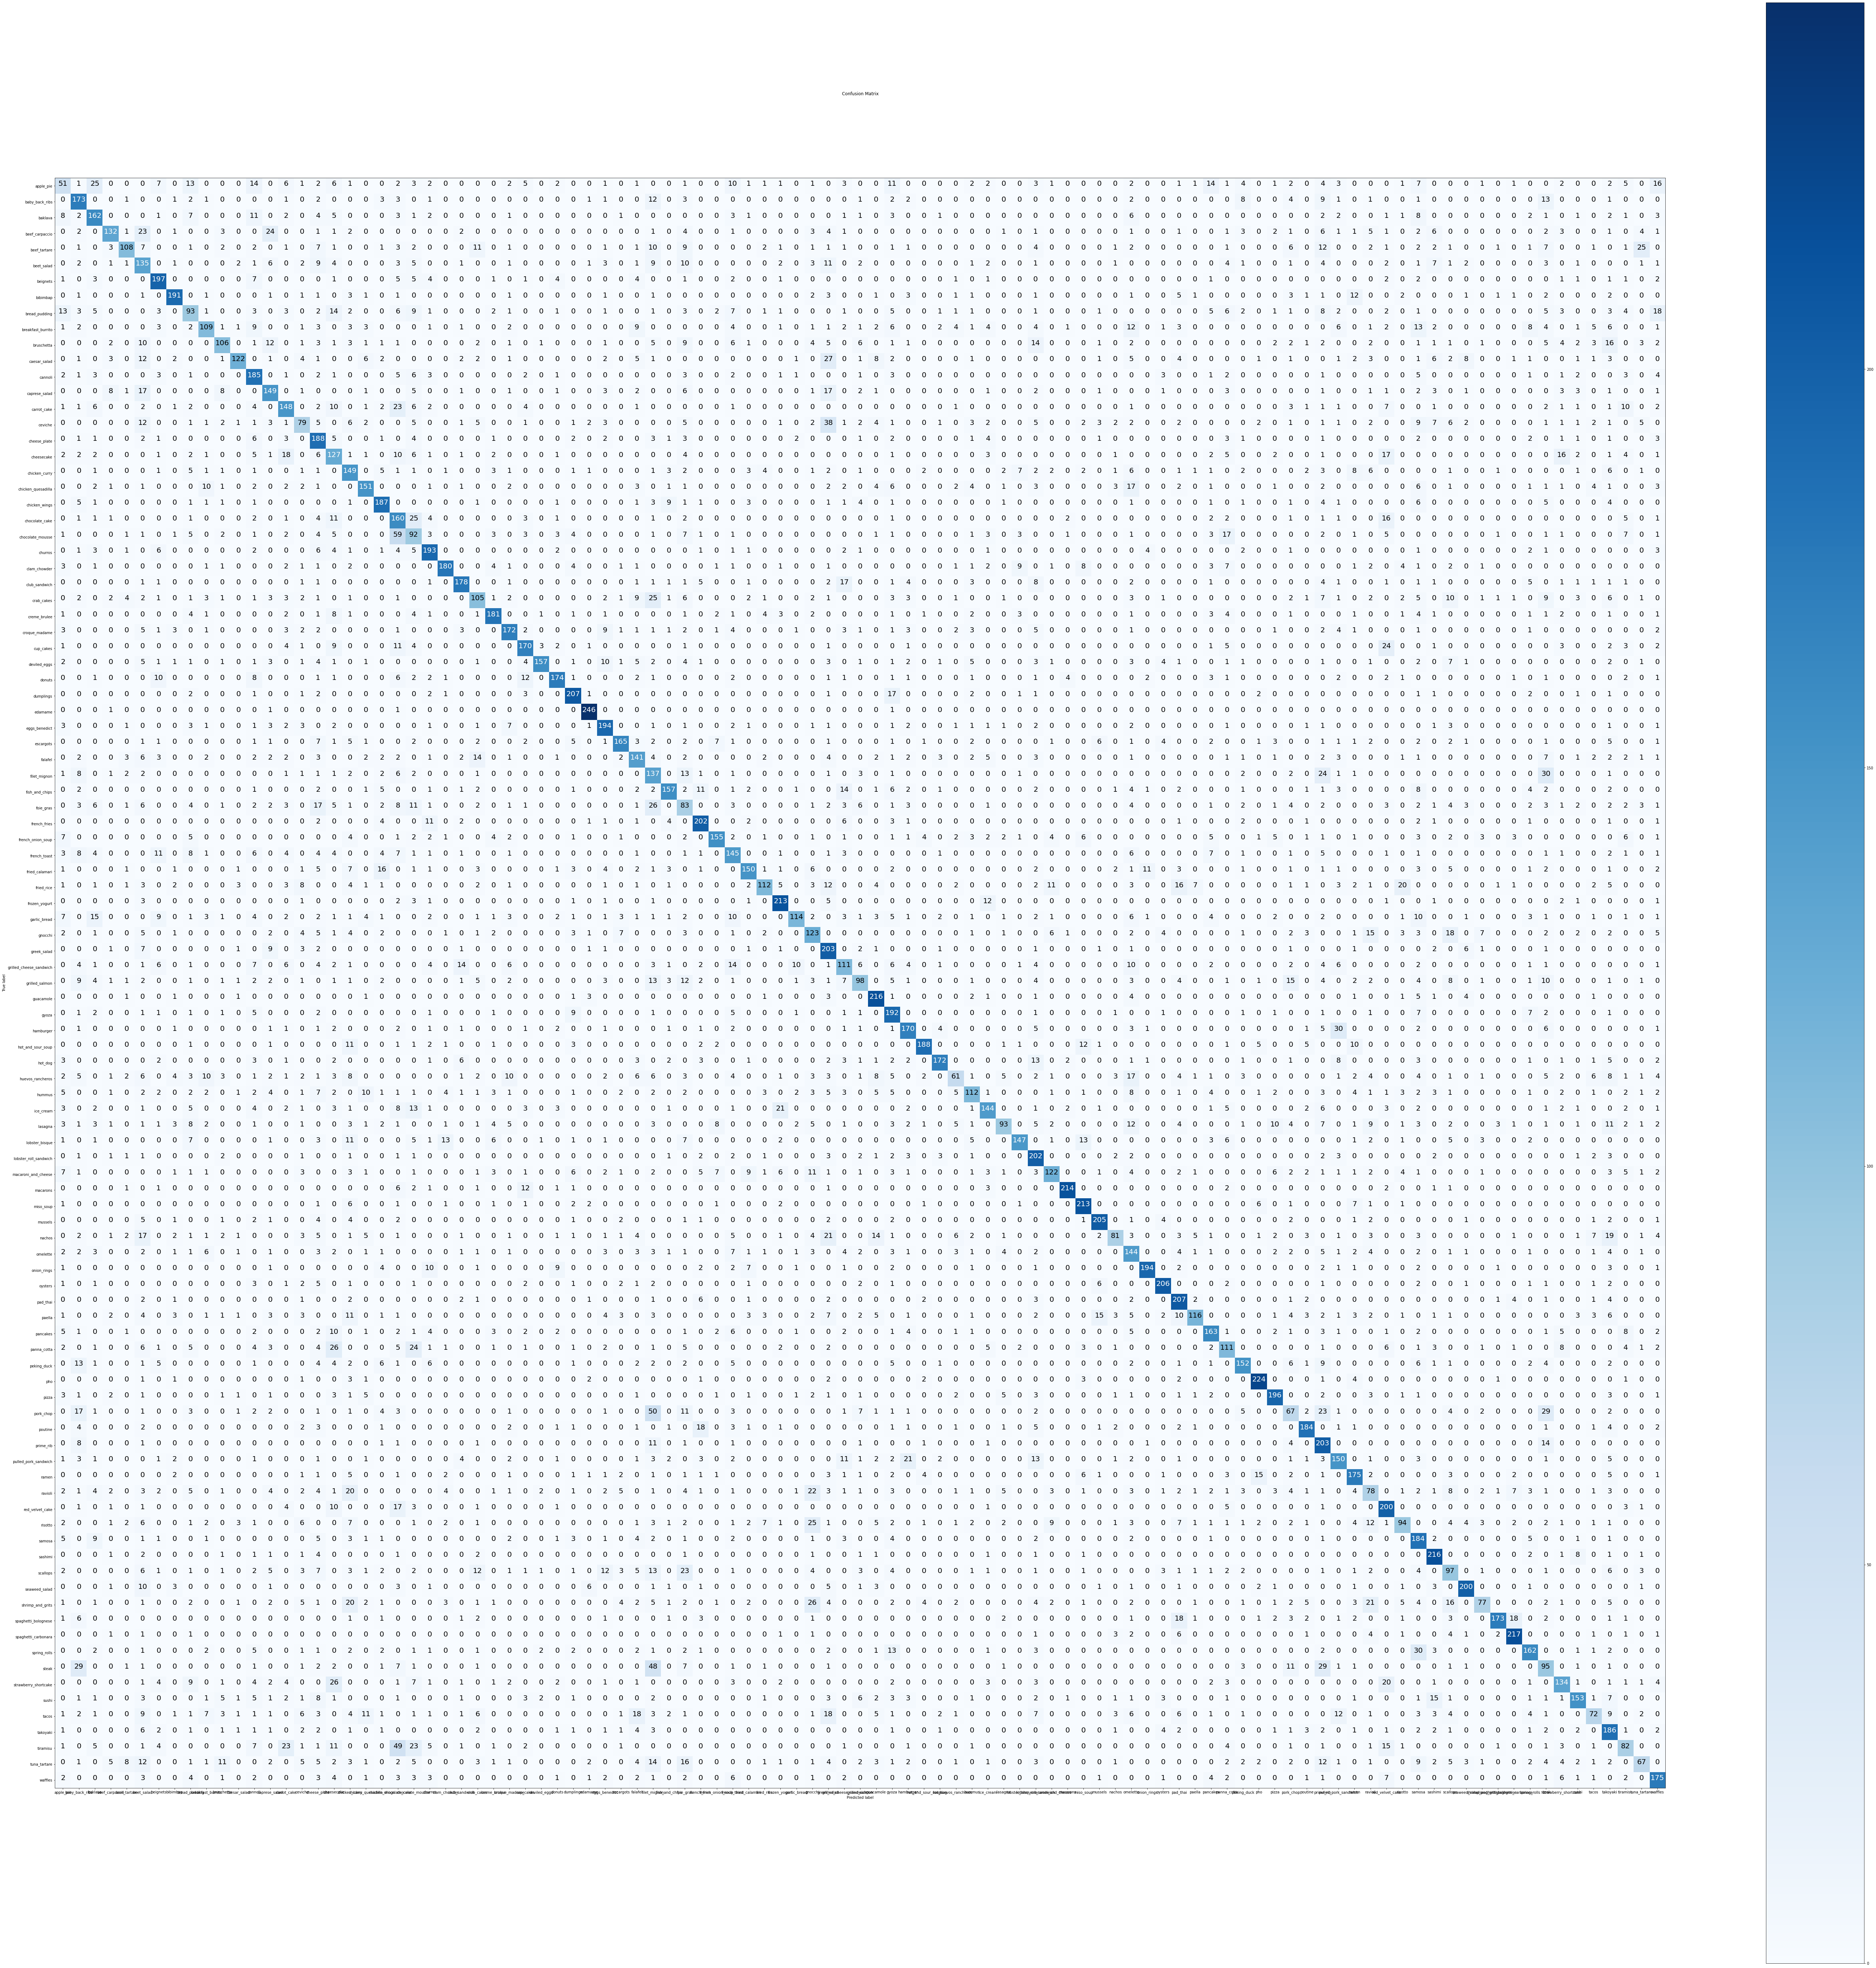

In [ ]:
from typing import Text
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize =(100, 100),
                      text_size = 20)

## Let's keep the evaluation train going, time for a classification report 

Scikit-learn has a helpful function for acquiring many different classificatin metrics per class (e.g. precision, recall, and F1) called `classification_report`, let's try it out.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true = y_labels,
                            y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [ ]:
# Get a dictionary of the classification report 
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

Let's plot all of our classes F-1 scores

In [ ]:
# create empty dictionary 
class_f1_scores = {}
# loop through classification report dictionary items 
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f-1 scores to new dictionary 
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                                              "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending = False)

In [ ]:
f1_scores[:10]

,class_names,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
68,onion_rings,0.832618
65,mussels,0.820000
88,seaweed_salad,0.813008
64,miso_soup,0.812977
45,frozen_yogurt,0.811429


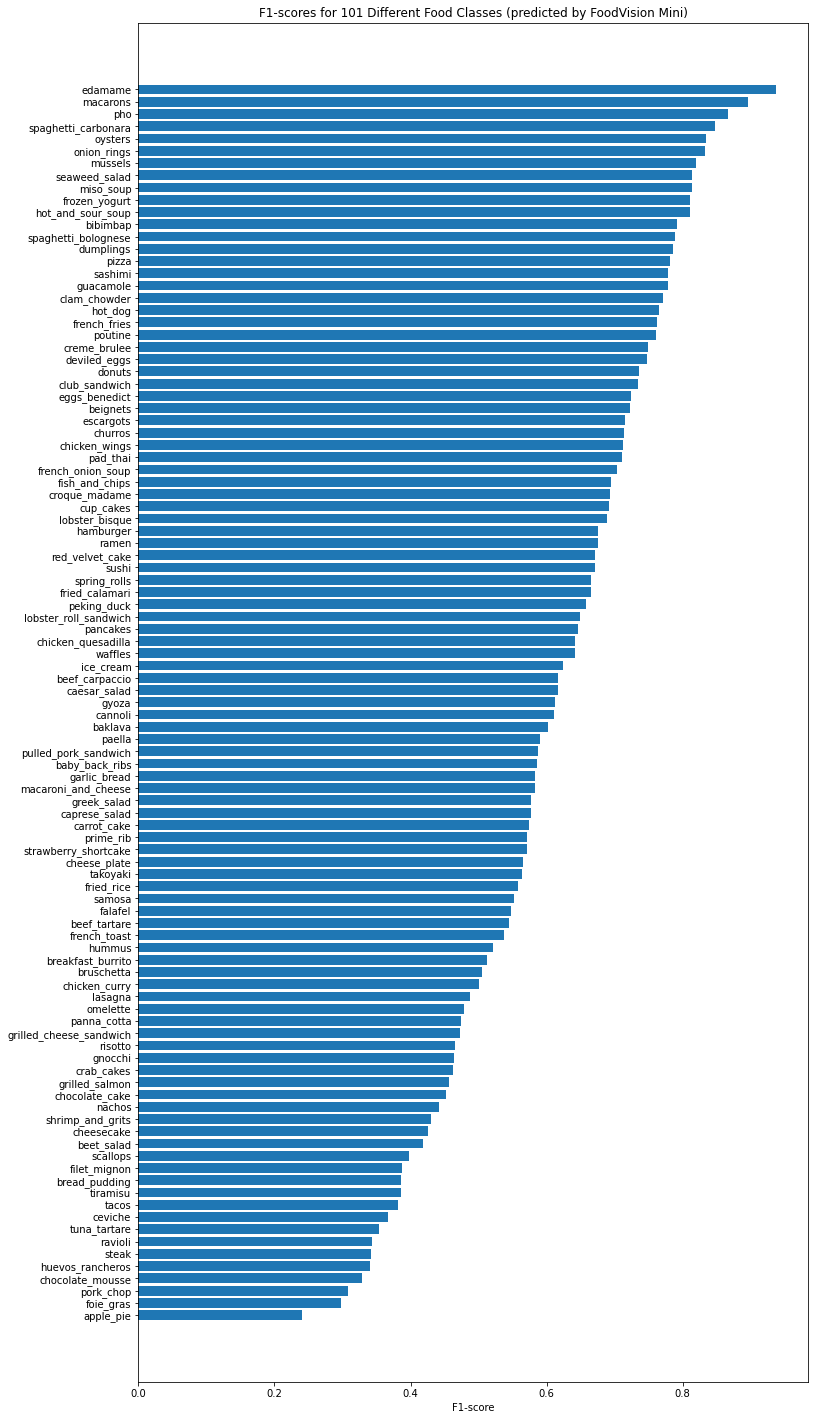

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by FoodVision Mini)")
ax.invert_yaxis();

## Visualizing predictions on custom images

(We will first do test images then custom images)
Let's create function to visualize our model's predictions on our own images, specifically it will need to: 
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values betwen 0 & 1 (if necessary)

This is the real test. How does our model do on food images not even in our test dataset? 



In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape = 224, scale=True):
  """
  reads in an image from filename, turns it into a tensor and reshapes into 
  specified shape (img_shape, img_shape, color_channels=3)

  Args:
    filename (str): path to target image
    img_shape (int): height/width dimensions of target image size 
    scale (bool): scale pixel values from 0-55 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor 
  img = tf.io.decode_image(img, channels = 3)

  # Resize image 
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale
  if scale:
    # Rescale image (get all values between 0 & 1)
    return img/255.
  else:
    return img

Now we've got a function to load and prepare target iamges ,let's now write some code to visualize iamges, their label and our model's predictions 

Specifically, we'll write some code to 
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, predction probability and truth label

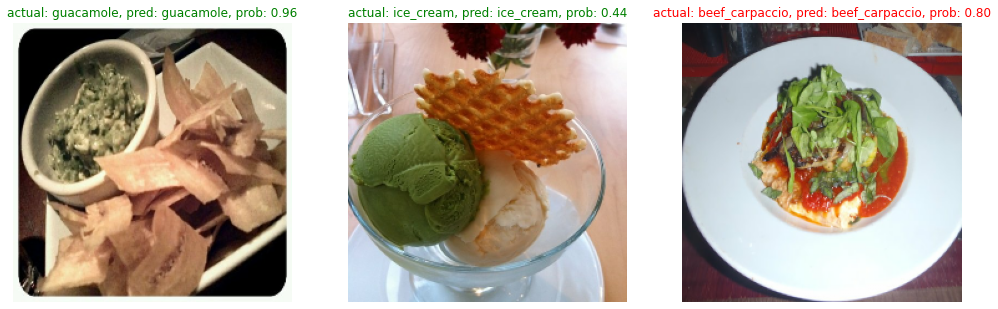

In [ ]:
# Make preds on a series of random images
import os 
import random

plt.figure(figsize = (17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir +"/" + class_name))
  filepath = test_dir + class_name +"/" + filename
  
  # load the image and make predictions 
  img = load_and_prep_image(filepath, scale =False)
  pred_prob = model.predict(tf.expand_dims(img,axis =0)) # get prediction probabilities array 
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index

  # Plot the iamge
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # if predicted class matches truth class, makes text green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {pred_class}, pred: {pred_class}, prob: {pred_prob.max():.2f}",c =title_color)
  plt.axis(False);

## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:

1. Get all of the image file paths in the test dataset using `list_files()` method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities. 
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction). 
4. Sort the DataFrame based on wrong predictions (have the highest predictions probabiity predictions at the top)
5. Visualize the images with the highest prediction probabilities but have the wrong prediction. 


In [ ]:
# 1. Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data_all_10_percent.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                                    shuffle = False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# 2. Create a pandas DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({'img_path': filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis =1),
                        "y_true_classnames": [class_names[i] for i in y_labels],
                        "y_pred_classnames":  [class_names[i] for i in pred_classes]})

In [ ]:
# 3. Find out in our DataFrame which predictions are wrong 
pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classnames,y_pred_classnames,pred_correct
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847418,apple_pie,gyoza,False
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie,True
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie,True
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658607,apple_pie,pulled_pork_sandwich,False
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367904,apple_pie,prime_rib,False


In [ ]:
# 4. Sort the DataFrame based on wrong predictions (have the highest predictions probability predictions at the top)
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending = False)[:100]
top_100_wrong

,img_path,y_true,y_pred,pred_conf,y_true_classnames,y_pred_classnames,pred_correct
21810,b'/content/101_food_classes_10_percent/test/sc...,87,29,0.999997,scallops,cup_cakes,False
231,b'/content/101_food_classes_10_percent/test/ap...,0,100,0.999995,apple_pie,waffles,False
15359,b'/content/101_food_classes_10_percent/test/lo...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
23539,b'/content/101_food_classes_10_percent/test/st...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
21400,b'/content/101_food_classes_10_percent/test/sa...,85,92,0.999981,samosa,spring_rolls,False
...,...,...,...,...,...,...,...
8763,b'/content/101_food_classes_10_percent/test/es...,35,41,0.997169,escargots,french_onion_soup,False
2663,b'/content/101_food_classes_10_percent/test/br...,10,61,0.997055,bruschetta,lobster_roll_sandwich,False
7924,b'/content/101_food_classes_10_percent/test/do...,31,29,0.997020,donuts,cup_cakes,False
18586,b'/content/101_food_classes_10_percent/test/pe...,74,39,0.996884,peking_duck,foie_gras,False


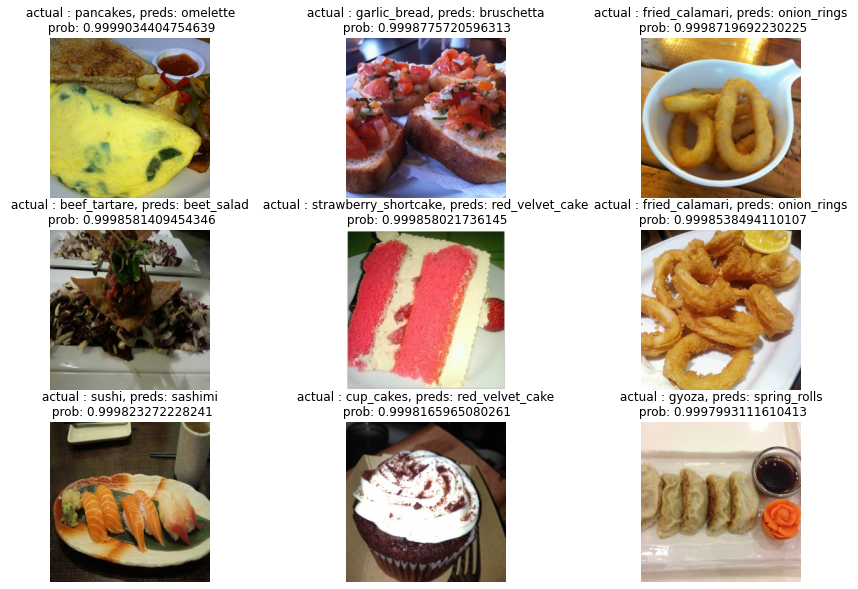

In [ ]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability
images_to_view = 9
start_index = 10
plt.figure(figsize= (15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index + images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale =False)
  _, _, _, _,pred_prob, y_true_classnames, y_pred_classnames, _  = row # only interested in a few parameters of each row
  plt.imshow(img/255.)
  plt.title(f" actual : {y_true_classnames}, preds: {y_pred_classnames} \n prob: {pred_prob}")
  plt.axis(False)
    